In [1]:
%matplotlib inline
import tensorflow as tf
from cdxbasics.config import Config, Int
from cdxbasics.prettydict import PrettyOrderedDict as pdct
from cdxbasics.dynaplot import figure
import numpy as np
import math as math
from IPython.display import display, Markdown
import ray
from ray.util.queue import Queue
import asyncio

import multiprocessing
ray.shutdown()
ray.init(num_cpus = 4) # Specify this system has 4 CPUs.

dtype = tf.float32
display(Markdown("## TensorFlow AMC"))
display(Markdown("TensorFlow V%s, Ray V%s with %s nodes" % (tf.__version__, ray.__version__, multiprocessing.cpu_count() )))

2023-02-23 19:11:12.232253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 19:11:12.486603: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 19:11:18,868	INFO worker.py:1538 -- Started a local Ray instance.


## TensorFlow AMC

TensorFlow V2.10.0, Ray V2.2.0 with 8 nodes

In [2]:
"""
Tensorflow AMC Pricer as function of Neural Networks
"""

class AMC(tf.keras.Model):
    
    def __init__(self, option, config = Config() ):
        tf.keras.Model.__init__(self, dtype=dtype, name="AMC")
        assert option.call_or_put in ['call', 'put'], "'call_or_put' must be 'call' or 'put'. Found '%s'" % option.call_or_put
        self.strike     = float(option.strike)
        self.cp         = 1. if option.call_or_put == "call" else -1.
        self.ex_mode    = config("ex_mode", "direct", ['direct','cutoff','implied'], "Exercise mode")
        self.width      = config("width", 50, Int>0, "Width")
        self.depth      = config("depth", 3, Int>0, "Depth")
        self.activation = config("activation", "relu", str, "Activation function")
        self.relative   = config.signal("relative", "spot", ['spot', 'intrinsic', 'none'], "Whether to make the signal relative to a quantity")
        self.smooth     = config.signal("smooth", True, bool, "Whether the signal is a smooth value between [0,1] or a digital value in {0,1}")
                
        self.label = "AMC %s%s%s" % ( "%s @ %g" % (option.call_or_put, self.strike), \
                                        (" rel to %s" % self.relative) if self.relative != 'none' else "", \
                                        " smooth" if self.smooth else " digital" )
            
    def build(self, shapes):
        nFeatures = 5  # tleft, spot, state, live, intrinsic
        nOutput   = 3  # action, "LSTM"
        inp       = tf.keras.layers.Input( shape=(nFeatures,), dtype=self.dtype )
        x         = inp
        x         = tf.keras.layers.Dense( units=self.width,
                                           activation=self.activation,
                                           use_bias=True, dtype=self.dtype )(x)
        for d in range(self.depth-1):
            x = tf.keras.layers.Dense( units=self.width,
                                       activation=self.activation,
                                       use_bias=True,dtype=self.dtype )(x)
        x = tf.keras.layers.Dense(     units=nOutput,
                                       activation="linear",
                                       use_bias=True,dtype=self.dtype)(x)
        self.exercise_model = tf.keras.Model( inputs=inp, outputs=x )
        self.initial_state  = tf.Variable( 0.,dtype=self.dtype )
        
    def call(self, spots, training=False):
        """ Execute core Monte Carlo """      
        nBatch    = spots.shape[0]
        nSteps    = int( spots.shape[1] )
        notional  = tf.ones_like(spots[:,0])                                        # residual notional left
        state     = tf.zeros_like(notional) + self.initial_state                    # recurrent state
        payoff    = tf.math.maximum( 0., self.cp * ( spots[:,-1] - self.strike ) )  # 
        exercsd   = tf.zeros_like(notional)[:,tf.newaxis]
        exercise  = tf.zeros_like(notional)
        t         = 0

        while t<nSteps-1:#tf.less(t,nSteps-1):
            #tf.autograph.experimental.set_loop_options( shape_invariants=[(exercsd, tf.TensorShape([None,None]))] )

            # call model
            tleft    = float(t+1)/float(nSteps) + spots[:,t] * 0.
            intrsc   = tf.math.maximum( 0., self.cp * ( spots[:,t] - self.strike ) )
            features = [ tleft, spots[:,t], state, notional, intrsc ]
            features = tf.concat( [ f[:,tf.newaxis] for f in features ], axis=1 )
            action   = self.exercise_model( features, training=training )

            # various ways to interpret the signal
            signal   = action[:,0]
            relative = spots[:,t] if self.relative == "spot" else intrsc
            signal   = (signal - relative) if self.relative != "none" else signal
            signal   = tf.sigmoid( signal ) if self.smooth else tf.where( tf.sigmoid( signal ) > 0.5, 1., 0. )

            # exercise: signal represents % of live notional to be exercised
            exercise = notional * signal
            payoff   = intrsc * exercise + (1.-exercise) * payoff 
            exercsd  = tf.concat( [ exercsd, exercise[:, tf.newaxis] ], axis=1 )
            notional = notional - exercise

            # exponential state update
            newstate = action[:,1]                               
            update   = tf.math.sigmoid( action[:,2] )
            state    = update * newstate + (1. - update) * state

            # loop
            t        = t+1

        return dict( loss=-payoff,
                     payoff=payoff,
                     exercsd=exercsd)

print("/Done")

/Done


In [8]:
"""
Define different congfigs
"""

option = pdct(strike=1.02, call_or_put = "put")

configs = []

config = Config()
config.signal.relative = 'none'
configs.append( config )

config = Config()
config.signal.relative = 'spot'
configs.append( config )

config = Config()
config.signal.relative = 'intrinsic'
configs.append( config )

labels = [ AMC( option, config ).label for config in configs ]
print(labels)


['AMC put @ 1.02 smooth', 'AMC put @ 1.02 rel to spot smooth', 'AMC put @ 1.02 rel to intrinsic smooth']


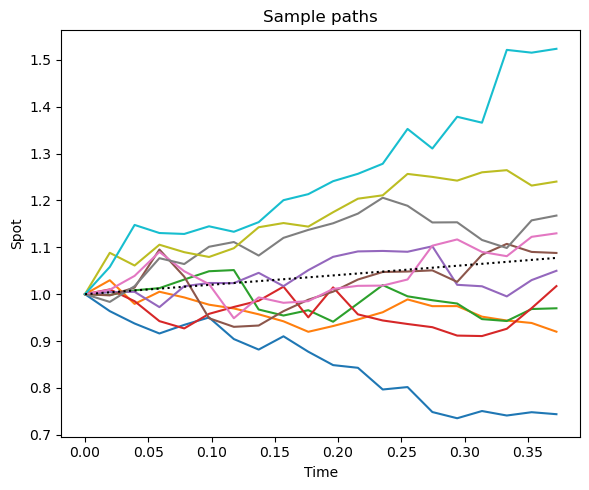

In [4]:
"""
Simple Black & Scholes Market Simulator
"""

# generate path
vol      = 0.2
drift    = 0.2
dt       = 1./255.*5.
nSteps   = 20
nSamples = 1000

dW       = np.random.normal( size=(nSamples, nSteps-1) )
dS       = drift * dt + vol * dW * math.sqrt(dt) - 0.5 * vol * vol * dt
S        = np.ones((nSamples,nSteps))
times    = np.linspace(0,nSteps-1,nSteps) * dt
S[:,1:]  = np.exp( np.cumsum( dS, axis=1 ) )
S        *= np.exp( times*drift ) / np.mean( S, axis=0 )[np.newaxis,:]
ixs      = np.argsort(S[:,-1])
S        = S[ixs,:]
times    = np.linspace(0,nSteps-1,nSteps) * dt

fig = figure(col_size=6, col_nums=1)
ax  = fig.add_subplot()
ax.set_title("Sample paths")
npl = 10
idx = np.linspace(0,nSamples-1,npl,endpoint=True,dtype=np.int32)
for i in idx:
    ax.plot( times, S[i,:] )
ax.plot( times, np.mean( S, axis=0 ), ":", color="black" )
ax.set_xlabel("Time")
ax.set_ylabel("Spot")
fig.render()
fig.close()

In [5]:
"""
Mini training to test it all works
"""

def default_loss(y_true,y_pred):
    """ Just minimize expected loss """
    return y_pred

for label, config in zip(labels,configs):
    print("Testing %s" % label)
    batch_size = None
    epochs = 2
    model  = AMC( option, config )
    tfS    = tf.convert_to_tensor( S, dtype=dtype)
    tfR    = model(tfS)
    model.compile(optimizer="adam", loss=dict(loss=default_loss))
    h = model.fit( x = tfS, y = tfS[:,-1],
               batch_size = batch_size, 
               epochs     = epochs,
               callbacks  = None,
               verbose    = 1 )

print("/done")

Testing AMC put @ 1.02 rel to spot smooth
Epoch 1/2
32/32 [==============================] - 13s 8ms/step - loss: -0.0261 - loss_loss: -0.0261
Epoch 2/2
32/32 [==============================] - 0s 9ms/step - loss: -0.0275 - loss_loss: -0.0275
Testing AMC put @ 1.02 smooth
Epoch 1/2
32/32 [==============================] - 12s 8ms/step - loss: -0.0245 - loss_loss: -0.0245
Epoch 2/2
32/32 [==============================] - 0s 7ms/step - loss: -0.0272 - loss_loss: -0.0272
Testing AMC put @ 1.02 rel to spot smooth
Epoch 1/2
32/32 [==============================] - 13s 10ms/step - loss: -0.0261 - loss_loss: -0.0261
Epoch 2/2
32/32 [==============================] - 0s 8ms/step - loss: -0.0276 - loss_loss: -0.0276
Testing AMC put @ 1.02 rel to intrinsic smooth
Epoch 1/2
32/32 [==============================] - 13s 8ms/step - loss: -0.0235 - loss_loss: -0.0235
Epoch 2/2
32/32 [==============================] - 0s 9ms/step - loss: -0.0252 - loss_loss: -0.0252
/done


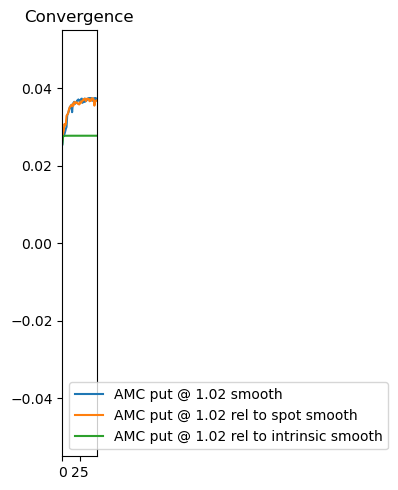

Ray training is starting...


(train_loop pid=18680) WARNING:tensorflow:AutoGraph could not transform <bound method AMC.call of <__main__.AMC object at 0x7f815eafd900>> and will run it as-is.
(train_loop pid=18680) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(train_loop pid=18680) Cause: Unknown node type <gast.gast.Import object at 0x7f811cbcd150>
(train_loop pid=18680) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(train_loop pid=18680) WARNING:tensorflow:AutoGraph could not transform <bound method AMC.call of <__main__.AMC object at 0x7f815eafd900>> and will run it as-is.
(train_loop pid=18680) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(train_loop pid=18680) Cause: Unknown node type <gast.gast.Import object at 0x7f811cbcd150>
(train_lo

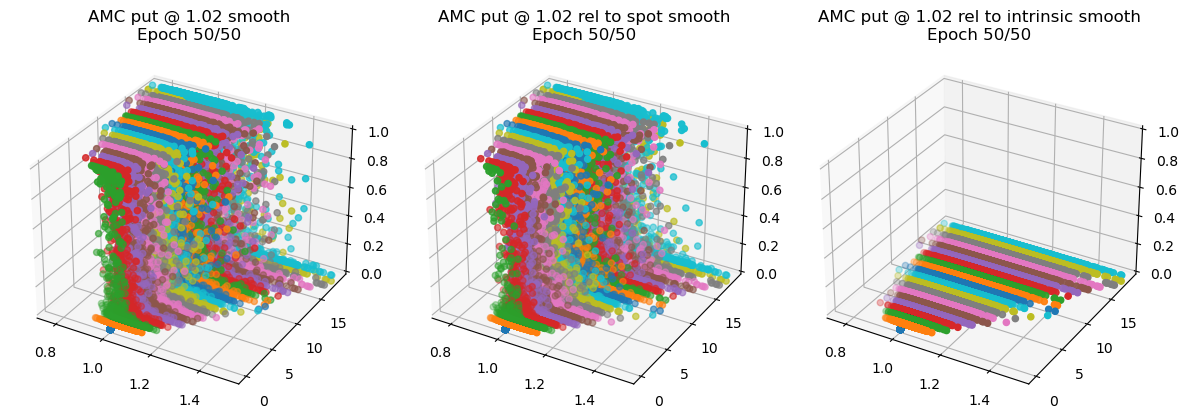

In [ ]:
"""
TensorFlow default training with a bit of gimmicky visualization (makes training slower)
"""

class Printer(object):
    
    def __init__(self, labels, configs, epochs, queue ):
        self.queue       = queue
        self.done        = [False]*len(labels)
        self.epochs      = epochs

        self.fig_all     = figure()
        self.ax_progress = self.fig_all.add_subplot()
        self.ax_progress.set_xlim(0,epochs-1)
        self.ax_progress.set_title("Convergence")
        self.ln_progress = [ self.ax_progress.plot( [0], [0], label=labels[ix] )[0] for ix in range(len(labels)) ]
        self.ax_progress.legend()
        self.lim_progress = None
        
        self.fig_all.render()
        
        self.fig_expr    = figure()
        self.ax_exprs    = [ self.fig_expr.add_subplot(projection="3d") for label in labels ]
        self.ln_exprs    = [ list() for label in labels ]
        for ix in range(len(labels)):
            self.ax_exprs[ix].set_title( labels[ix] )
            self.ax_exprs[ix].set_xlim( np.min(S), np.max(S) )
            self.ax_exprs[ix].set_zlim(0.,1.)

    def update_loop( self ):
        
        while True:
            data = self.queue.get()
            if data.done:
                assert not self.done[data.ix]
                self.done[data.ix] = True
                if sum(self.done) == 0:
                    return
            else:
                # progress
                ln = self.ln_progress[data.ix]
                ep = len(data.hist)
                ln.set_xdata( np.linspace(0,ep-1,ep) )
                ln.set_ydata( data.hist )
                self.lim_progress = ( min(data.hist), max(data.hist) ) if self.lim_progress is None else ( min(self.lim_progress[0],min(data.hist)), max(self.lim_progress[1],max(data.hist)) ) 
                ##self.ax_progress.set_ylim( self.lim_progress )
                self.fig_all.render()

                # exercise region#
                notional_exercised = np.cumsum( data.exercsd, axis=1 )
                assert notional_exercised.shape == (len(S[:,-1]), nSteps) 
                lines = self.ln_exprs[data.ix]
                for _ in lines:
                    _.remove()
                self.ln_exprs[data.ix] = [ self.ax_exprs[data.ix].scatter( S[:,t], S[:,t]*0.+t, notional_exercised[:,t] ) for t in range(notional_exercised.shape[1]) ]
                self.ax_exprs[data.ix].set_title( labels[data.ix] + "\nEpoch %ld/%ld" % (len(data.hist),self.epochs) )
                self.fig_expr.render()


batch_size = None
epochs = 50 
queue = Queue()

@ray.remote
def train_loop( *, ix, config, option, S, queue, epochs, batch_size ):
    from cdxbasics.config import Config, Int
    from cdxbasics.prettydict import PrettyOrderedDict as pdct
    import tensorflow as tf
    import numpy as np

    def default_loss(y_true,y_pred):
        """ Just minimize expected loss """
        return y_pred

    class Callback( tf.keras.callbacks.Callback ):
        """
        Only used to plot during training
        """
        def __init__(self, ix, queue):
            tf.keras.callbacks.Callback.__init__(self)
            self.ix      = ix
            self.queue   = queue
            self.history = []
            self.volhist = []

        def on_epoch_end( self, loop_epoch, logs = None ):
            # get latest model results
            label    = model.label
            tfR      = model(tfS)
            exercsd  = np.array( tfR['exercsd'] )
            self.history.append( np.mean( tfR['payoff'] ) )
            self.queue.put( pdct(ix=self.ix,
                                 done=False, 
                                 hist=np.array( self.history ), 
                                 exercsd=exercsd
                                ) )

        def done(self):
            self.queue.put( pdct(ix=self.ix, done=True ) )
            
    model = AMC( option, config )
    tfS   = tf.convert_to_tensor( S, dtype=dtype)
    tfR   = model(tfS)
    model.compile(optimizer="adam", loss=dict(loss=default_loss))
    model.fit( x = tfS, y = tfS[:,-1],
               batch_size = batch_size, 
               epochs     = epochs,
               callbacks  = Callback(ix, queue),
               verbose = 0 )

S_ref    = ray.put(S)
printer  = Printer( labels, configs, epochs, queue )
futures  = [ train_loop.remote( ix=ix, config=ray.put(configs[ix]), S=S_ref, option=option, queue=queue, epochs=epochs, batch_size=batch_size) for ix in range(len(configs)) ]
    
print("Ray training is starting...")
try:
    printer.update_loop()
except KeyboardInterrupt:
    print("Ctrl+C")

print("Cleaning up...")
for f in futures:
    ray.cancel( f )
            
del printer
    

In [7]:
x = [False, False, False]
sum(x)

0